# EDA - 120 years of Olympic history #

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
full_data = pd.read_csv("../data/athlete_events.csv")

In [3]:
full_data.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [4]:
# lower the features names
full_data.columns = [x.lower() for x in full_data.columns.tolist()]

In [5]:
full_data.id.unique().shape

(135571,)

There are 271116 samples, each representing a result from an athlete, and there are 135571 different athletes. 

## Missing values ##

In [6]:
full_data.notna().all(axis=0) # if there are missing values in the column

id         True
name       True
sex        True
age       False
height    False
weight    False
team       True
noc        True
games      True
year       True
season     True
city       True
sport      True
event      True
medal     False
dtype: bool

The only features having missing values are age, height, weight and medals.

In [7]:
missing_features = full_data[['age', 'height', 'weight']].notna().all(axis=1).value_counts() #counts of rows for which we have at least a missing entry
missing_features

True     206165
False     64951
dtype: int64

On these features, we have around 24% percent of entries with at least one missing value. But these missing values could come from the same athletes every year. The idea is that if we know one of these features for an athlete at a given year, we could fill all the missing entries of that features for this athlete.

In [8]:
id_missing_features = full_data[['id', 'age', 'height', 'weight']]
id_missing_features.age = id_missing_features.age.notna()
id_missing_features.height = id_missing_features.height.notna()
id_missing_features.weight = id_missing_features.weight.notna()
id_missing_features.head()

/Users/sylvainlugeon/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,id,age,height,weight
0,1,True,True,True
1,2,True,True,True
2,3,True,False,False
3,4,True,False,False
4,5,True,True,True


In [9]:
id_missing_features.groupby('id').any().sum() # if we have the given feature for at least a year

age       129203
height    101655
weight    100686
dtype: int64

In [10]:
id_missing_features.groupby('id').all().sum() # if we have the given feature for all year

age       129203
height    101655
weight    100686
dtype: int64

We can see that the missing values in the db have already been filled, so we can't infer the age, weight or height for an athlete at a given year by looking at the entries at another year. Over all we have for the athletes:
- 4.7% missing age
- 25% missing height
- 25.7% missing weight

Now let's look at the distribution of the missing data according to the year and the sport.

In [11]:
athletes_missing_features = full_data.copy()
athletes_missing_features.drop_duplicates(subset='id', inplace=True) # drop duplicates in the athletes
athletes_missing_features['missing_features'] = athletes_missing_features[['age', 'height', 'weight']].notna().all(axis=1) #if all the features are well defined for that row
athletes_missing_features.head()

,id,name,sex,age,height,weight,team,noc,games,year,season,city,sport,event,medal,missing_features
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,True
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,True
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,False
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,False
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,True


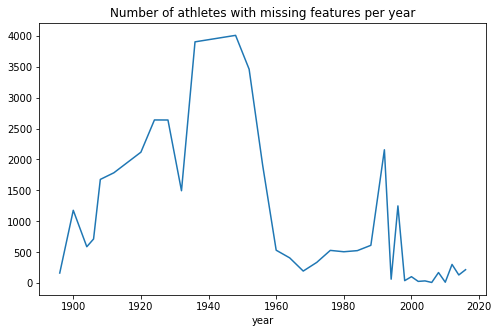

In [13]:
year_missing = athletes_missing_features[~athletes_missing_features.missing_features].groupby('year').id.count() # number of rows with missing entries per year

fig, ax = plt.subplots(figsize=(8,5))
ax.set_title('Number of athletes with missing features per year')
year_missing.plot();



Most of the missing values come from years before 1960. We also have a hub of missing values around 1990, it could be interesting to know why... (Cold War???)

In [17]:
sport_missing = athletes_missing_features[~athletes_missing_features.missing_features].groupby('sport').id.count()
sport_missing.sort_values(ascending=False, inplace=True)
sport_missing.sum() # we verify that the sum correspond to previous result

36483

In [18]:
sport_missing[:10]

sport
Athletics           3831
Rowing              2388
Swimming            2187
Football            2151
Gymnastics          1950
Art Competitions    1784
Fencing             1732
Shooting            1637
Cycling             1594
Boxing              1588
Name: id, dtype: int64

The ten sport that have athletes with the most frequent missing values appear to be popular sports, surprisingly! But do athletes with medals also have missing values?

In [19]:
athletes_with_medals = athletes_missing_features[athletes_missing_features.medal.notna()]
athletes_with_medals.groupby('missing_features').id.count()

missing_features
False     5644
True     13507
Name: id, dtype: int64

So when only taken into account the athletes with medals, we have 29% of athletes with at least a missing features.

## Basics statistics

In [20]:
sports = full_data.groupby('sport').id.count().sort_values(ascending=False)

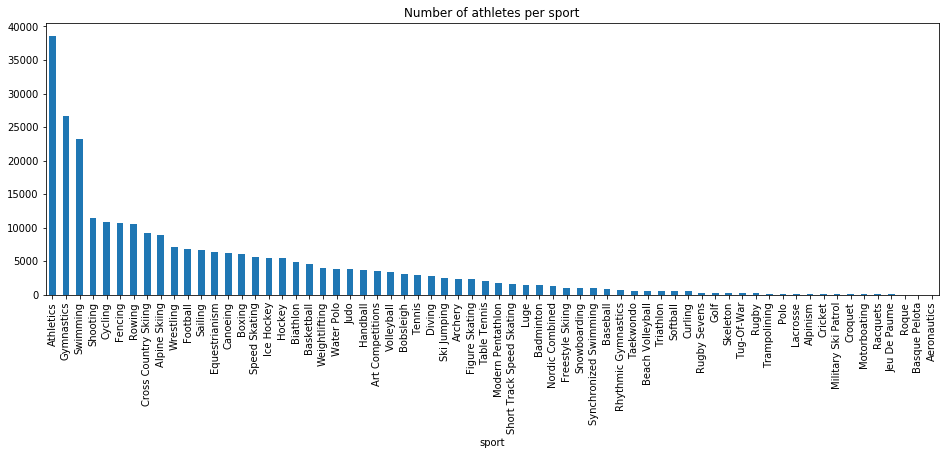

In [21]:
fig, ax = plt.subplots(figsize=(16,5))
sports.plot.bar()
plt.xticks(rotation=90)
ax.set_title('Number of athletes per sport')
plt.show()


Above is the number of athlete per sports, there are 66 differents sports, most popular ids by far ar Athletics, Gymnastics and Swimming.

In [22]:
athletes_countries = full_data.groupby('noc').count() # athletes and medals (count ignore nan) per countries
athletes_countries.sort_values(by='id', ascending=False, inplace=True)

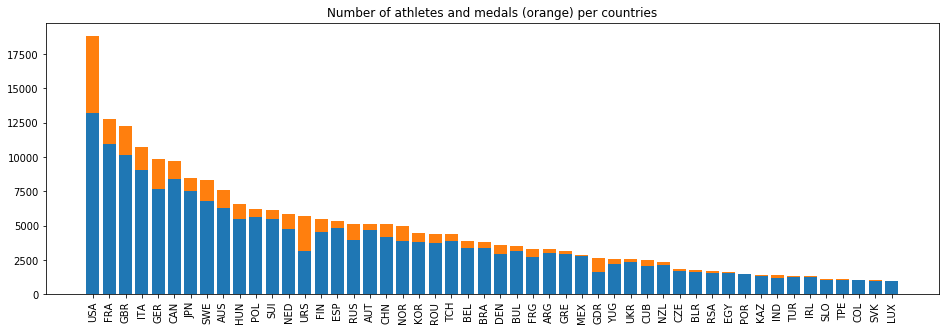

In [23]:
fig, ax = plt.subplots(figsize=(16,5))

nb_displayed = 50

labels = athletes_countries.index.values[:nb_displayed]
no_medals = athletes_countries.id.values[:nb_displayed] - athletes_countries.medal.values[:nb_displayed]
medals = athletes_countries.medal.values[:nb_displayed]

ax.bar(labels, no_medals)
ax.bar(labels, medals, bottom=no_medals)

plt.xticks(rotation=90)

ax.set_title('Number of athletes and medals (orange) per countries')


plt.show()

Above is the total number of athletes and number of medals for each countries.

In [24]:
athletes_year_summer = full_data[full_data.season == 'Summer'].groupby('year').id.count()
athletes_year_winter = full_data[full_data.season == 'Winter'].groupby('year').id.count()

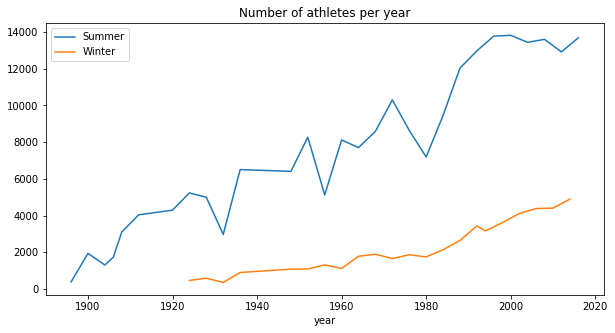

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
athletes_year_summer.plot.line(label='Summer')
athletes_year_winter.plot.line(label='Winter')
ax.set_title('Number of athletes per year')
ax.legend()
plt.show()

The number of athlete is globally inceasing. But we remark that there is a drop in the number of athletes for certain years.

## Closer look at the USA

The goal of this section is to have a look at the evolution within the USA athletes.

In [47]:
usa = full_data.copy()
usa = usa[(usa.noc == 'USA') & (usa.season == 'Summer')]

In [59]:
usa_athletes_year = usa.groupby('year')[['id', 'medal']].count()

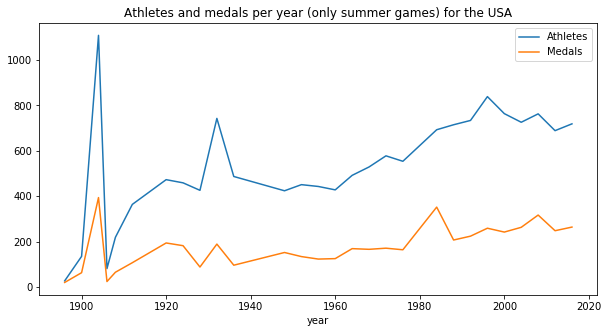

In [60]:
fig, ax = plt.subplots(figsize=(10,5))
usa_athletes_year.id.plot.line(label='Athletes')
usa_athletes_year.medal.plot.line(label='Medals')
ax.set_title('Athletes and medals per year (only summer games) for the USA')
ax.legend()
plt.show()

Huge peak in 1904! Otherwise, the number of athletes and medals is globally increasing. The ratio medals/athletes seems to be more or less constant.

In [67]:
usa_athletes_year['medals_ratio'] = usa_athletes_year.apply(lambda row : row.medal / row.id, axis=1)

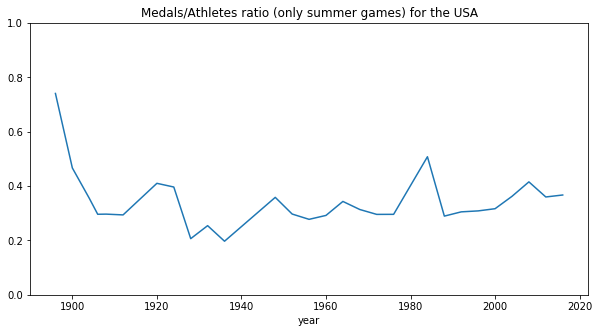

In [72]:
fig, ax = plt.subplots(figsize=(10,5))
usa_athletes_year.medals_ratio.plot.line()
ax.set_title('Medals/Athletes ratio (only summer games) for the USA')
ax.set_ylim(0,1)
plt.show()

Since 1950, the ratio remains pretty constant (except for the year 1984)

## Closer look at Athletics

In [81]:
athletics = full_data.copy()
athletics = athletics[athletics.sport == 'Athletics']

In [119]:
events_athletics = athletics.groupby('event').id.count().sort_values(ascending=False)
events_athletics

event
Athletics Men's Marathon                     2093
Athletics Men's 100 metres                   1936
Athletics Men's 4 x 100 metres Relay         1910
Athletics Men's 4 x 400 metres Relay         1749
Athletics Men's 200 metres                   1495
                                             ... 
Athletics Men's 4,000 metres Steeplechase       8
Athletics Men's 2,590 metres Steeplechase       7
Athletics Men's Shot Put, Both Hands            7
Athletics Men's All-Around Championship         7
Athletics Men's 2,500 metres Steeplechase       6
Name: id, Length: 83, dtype: int64

There are 83 different discipline in 'Athletics'. Some are very popular, some less.

In [124]:
athletics.groupby('id').event.count().sort_values(ascending=False) #number of event for each athlete

id
68647     22
90007     19
109597    15
89220     12
87390     12
          ..
56414      1
56409      1
56402      1
56393      1
43269      1
Name: event, Length: 22071, dtype: int64

And some athletes participate at several events!

In [94]:
medals_athletics = athletics.groupby('noc').medal.count().sort_values(ascending=False)

In [96]:
medals_athletics[:10]

noc
USA    1080
GBR     338
URS     242
JAM     156
GER     154
GDR     140
FIN     138
SWE     128
FRA     116
RUS     103
Name: medal, dtype: int64

The ten countries that have won the most medals in athletics. USA is by far at the head, following by the UK and Russia.

In [105]:
athletics_year = athletics.groupby('year').id.count()

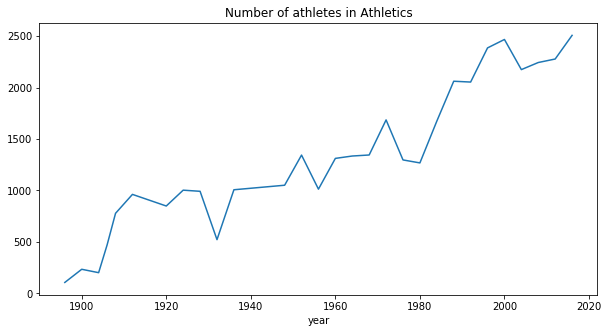

In [109]:
fig, ax = plt.subplots(figsize=(10,5))
athletics_year.plot.line()
ax.set_title('Number of athletes in Athletics')
plt.show()

The number of athletes competiting in Athletics is overall increasing, despite it is one the the oldest sports.

In [169]:
athletics_physic_relay = athletics[athletics.event == "Athletics Men's 4 x 100 metres Relay"].groupby('year')[['age', 'height', 'weight']].mean()

In [170]:
athletics_physic_relay.head()

,age,height,weight
year,,,
1912,22.515152,179.095238,70.368421
1920,23.120000,177.562500,71.142857
1924,23.905660,174.333333,67.781250
1928,22.347826,174.809524,67.937500
1932,22.965517,175.708333,69.555556


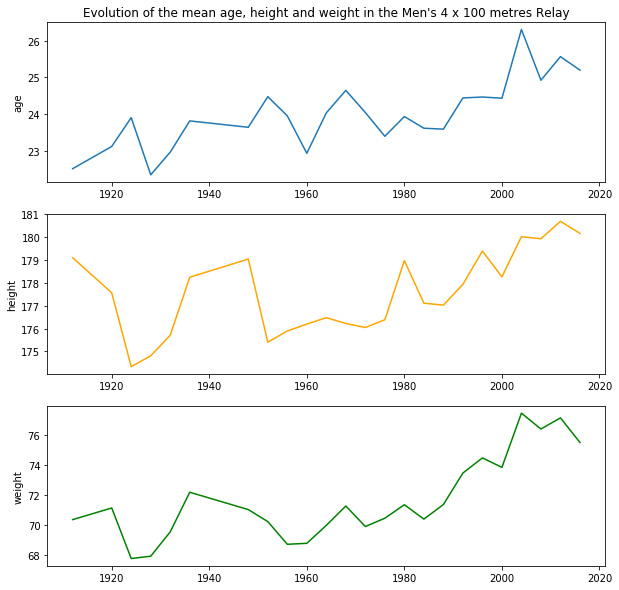

In [171]:
fig = plt.figure(figsize=(10,10))

ax = plt.subplot(311)
athletics_physic_relay.age.plot.line()
ax.set_ylabel('age')
ax.set_xlabel('')
ax.set_title("Evolution of the mean age, height and weight in the Men's 4 x 100 metres Relay")

ax2 = plt.subplot(312)
athletics_physic_relay.height.plot.line(color='orange')
ax2.set_ylabel('height')
ax2.set_xlabel('')

ax3 = plt.subplot(313)
athletics_physic_relay.weight.plot.line(color='green')
ax3.set_ylabel('weight')
ax3.set_xlabel('')

plt.show()

There seem to be an evolution in the physic carachteristics of the athletes competing in the Men's 4 x 100 metres Relay. Age, height and weight seem to have increased in the recent years. Let's look at another discipline: Men's Marathon.

In [172]:
athletics_physic_mara = athletics[athletics.event == "Athletics Men's Marathon"].groupby('year')[['age', 'height', 'weight']].mean()

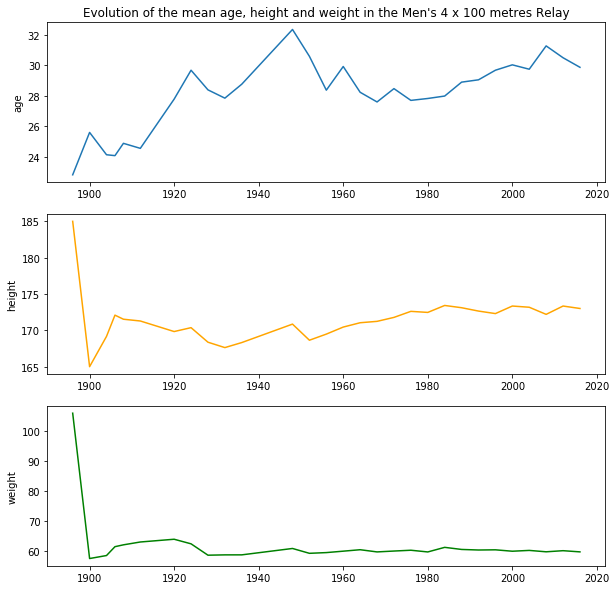

In [173]:
fig = plt.figure(figsize=(10,10))

ax = plt.subplot(311)
athletics_physic_mara.age.plot.line()
ax.set_ylabel('age')
ax.set_xlabel('')
ax.set_title("Evolution of the mean age, height and weight in the Men's 4 x 100 metres Relay")

ax2 = plt.subplot(312)
athletics_physic_mara.height.plot.line(color='orange')
ax2.set_ylabel('height')
ax2.set_xlabel('')

ax3 = plt.subplot(313)
athletics_physic_mara.weight.plot.line(color='green')
ax3.set_ylabel('weight')
ax3.set_xlabel('')

plt.show()

In marathon, the weight hasn't change much and has always been the smallest possible. But there age and height have increased over the years.